# Supplementary Table 7. DROSHA processing with SRSF3
---

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2021-01-05.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
utilpath = '/casa/bsc/notebooks/'
import sys; sys.path.append(utilpath)
from util import *

In [4]:
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/210105/


In [5]:
from __future__ import division
import pandas as pd
import numpy as np
import re
import gzip
from scipy.stats import pearsonr, spearmanr
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
%matplotlib inline

### 1. List up pri-miRNAs with redundant construct sequence

In [6]:
s1 = pd.read_csv('supplementary/201110_s1_pri-info.csv', header=1, index_col=0)
s2 = pd.read_csv('supplementary/201012_s2_pri-construct.csv', index_col=0, header=1)
s6 = pd.read_csv('supplementary/201012_s6_cleavage-patterns.csv', header=1, index_col=0)
print 's1:\t%s'%', '.join(list(s1.columns))
print 's2:\t%s'%', '.join(list(s2.columns)[:6])
print 's6:\t%s'%', '.join(list(s6.columns)[-4:])

s1:	5p mature, 5p sequence, 3p mature, 3p sequence, Note
s2:	Chr, Start, End, Strand, Construct sequence, 100way phyloP scores (pre-miRNA -/+ 100nt)
s6:	Relative position from miRBase site, Cleavage Specificity, Cleavage Imbalance, Cleavage type


In [7]:
singlemp = set(s6[s6['Cleavage type']=='single'].index)
multimp = set(s6[s6['Cleavage type']=='multiple'].index)
invertedmp = set(s6[s6['Cleavage type']=='inverted'].index)
nick5mp = set(s6[s6['Cleavage type']=='nick5'].index)
nick3mp = set(s6[s6['Cleavage type']=='nick3'].index)
nickmp = list(nick5mp) + list(nick3mp)
nonspecmp = set(s6[s6['Cleavage type']=='non-specific'].index)
dcsmirsmp = list(singlemp) + list(multimp)
nodcsmp = list(invertedmp) + list(nickmp) + list(nonspecmp)
print 'Productive: %s, Unproductive: %s' % (len(dcsmirsmp), len(nodcsmp))
print 'Single: %s, Multiple: %s, Inverted: %s, Nick: %s, Non-specific: %s'\
% (len(singlemp), len(multimp), len(invertedmp), len(nickmp), len(nonspecmp))
print "5' nick: %s, 3' nick: %s" % (len(nick5mp), len(nick3mp))

Productive: 512, Unproductive: 1304
Single: 445, Multiple: 67, Inverted: 156, Nick: 107, Non-specific: 1041
5' nick: 72, 3' nick: 35


In [8]:
def mirbase_to_relative_pos(mir, c5, c3):
    ps, pe, strand = s2.loc[mir, ['Start','End','Strand']]
    if strand=='+':
        return c5-ps+1, c3-ps+1
    return pe-c3+1, pe-c5+1

In [9]:
allpris = s1.index
preposition = {}
for mir in allpris:
    ps, pe = get_pre_annot(mir)[1:3]
    rps, rpe = mirbase_to_relative_pos(mir,ps,pe)
    preposition[mir] = (rps, rpe)
print len(preposition), preposition['hsa-mir-142']

1881 (32, 90)


In [10]:
redund = s2[s2['Note'].apply(lambda x: str(x).find('Same construct')>=0)]
repreRedund = defaultdict(list)
for pri, note in dict(redund['Note']).items():
    repre = note.split()[-1]
    repreRedund[repre].append(pri)
print len(repreRedund)

25


### 2. Input

In [11]:
datapath = '../2009_srsf3_hiseq/alignments'

In [15]:
allinputs = [ 'input_1', 'input_2' ]
inptbl = pd.DataFrame(columns=['Pri-miRNA']+allinputs)
inptbl['Pri-miRNA'] = allpris
inptbl = inptbl.set_index('Pri-miRNA').fillna(0)

In [16]:
for lib in allinputs:
    txt = '%s/%s.txt.gz' % (datapath,lib)
    mirs = !zcat $txt | cut -d" " -f1
    adjmirs = [ 'hsa-mir-1302-11' if m=='hsa-mir-1302-2' else m for m in mirs ]
    mircnts = pd.Series(Counter(adjmirs))
    inptbl[lib].update(mircnts)

In [12]:
#inptbl.to_csv('%s/input_counts.csv'%datapath)
inptbl = pd.read_csv('%s/input_counts.csv'%datapath,index_col=0)

In [13]:
for pri in inptbl.index:
    if pri in repreRedund:
        for pri2 in repreRedund[pri]:
            inptbl.loc[pri2] = inptbl.loc[pri]
inptbl = inptbl.sort_index()

In [14]:
inptbl.head(3)

,input_1,input_2
Pri-miRNA,,
hsa-let-7a-1,6675,6846
hsa-let-7a-2,15458,17160
hsa-let-7a-3,29955,27010


Text(0.5,1,u'2009 Hiseq: input')

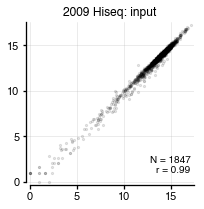

In [15]:
inpdet = inptbl[inptbl.sum(axis=1)>0]
xs = np.log2(inpdet['input_1']+1)
ys = np.log2(inpdet['input_2']+1)
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(xs,ys,s=5,color='k',alpha=.1, zorder=2)
ax.grid(ls='-',lw=.5)
ax.set_xlim(-max(xs)*.02, max(xs)*1.02)
ax.set_ylim(-max(ys)*.02, max(ys)*1.02)
ax.spines['bottom'].set_bounds(0,max(xs)*1.02)
ax.spines['left'].set_bounds(0,max(ys)*1.02)
r = pearsonr(xs,ys)[0]
ax.text(max(xs),1,'N = %s\nr = %.2f'%(len(inpdet),r), ha='right')
ax.set_title('2009 Hiseq: input', fontsize=12)

In [16]:
rcutoff = 30
suffinps = sorted([ mir for mir in allpris if inptbl.loc[mir].sum()>=rcutoff ])
print len(suffinps)

1815


### 3. Cleavage products

In [12]:
prev = pd.read_csv('../2009_srsf3_hiseq/alignments/cleaved_count.csv',index_col=0)
prev.head(1)

,Pri-miRNA,rstart,rend,cleaved_1,cleaved_2
0,hsa-let-7a-1,1,7,0,5


In [13]:
def cigar_to_len(cigar):
    nums = re.split('[A-Z]', cigar)[:-1]
    strs = re.split('[0-9]+', cigar)[1:]
    rlen = sum([int(number) for number, cigStr in zip(nums, strs) if cigStr in 'DM'])
    return rlen

In [14]:
allclvs = 'cleaved_1 cleaved_2'.split()
adaptlen = 20

In [32]:
d = {}
for lib in allclvs:
    summaryfile = '%s/%s.txt.gz' % (datapath,lib)
    tbl = pd.read_table(gzip.open(summaryfile, 'rb'), sep=' ',
                        names=['Pri-miRNA', 'start_R2', 'cigar', 'start_R1'])
    tbl['rstart'] = tbl['start_R1'].apply(lambda x: max(1, x-adaptlen))
    tbl['rlen'] = tbl['cigar'].apply(cigar_to_len)
    tbl['rend_tmp'] = tbl['start_R2']+tbl['rlen']-1
    tbl['rend'] = tbl['rend_tmp'].apply(lambda x: min(125, x-adaptlen))
    cnttbl = tbl.groupby(['Pri-miRNA', 'rstart', 'rend']).size()
    d[lib] = cnttbl

In [15]:
d,dupls = {},{}
for lib in allclvs:
    summaryfile = '%s/%s.multi.txt.gz' % (datapath,lib)
    tbl = pd.read_table(gzip.open(summaryfile, 'rb'), sep=' ',
                        names=['Read','Pri-miRNA', 'start_R2', 'cigar', 'start_R1'])
    tbl['rstart'] = tbl['start_R1'].apply(lambda x: max(1, x-adaptlen))
    tbl['rlen'] = tbl['cigar'].apply(cigar_to_len)
    tbl['rend_tmp'] = tbl['start_R2']+tbl['rlen']-1
    tbl['rend'] = tbl['rend_tmp'].apply(lambda x: min(125, x-adaptlen))
    tbl = tbl[(tbl['rend']-tbl['rstart'])>=10]
    multicnts = Counter(tbl['Read'])
    for (pri,st,en),grp in tbl.groupby(['Pri-miRNA','rstart','rend']):
        mcnt = multicnts[grp['Read'].tolist()[0]]
        dupls[(pri,int(st),int(en))] = mcnt
    cnttbl = tbl.groupby(['Pri-miRNA','rstart','rend']).size()
    d[lib] = cnttbl

In [16]:
clvtbl = pd.DataFrame(d).fillna(0).astype(int).reset_index()
unclv = clvtbl[(clvtbl['rstart']==1)&(clvtbl['rend']==125)]
clvtbl = clvtbl.drop(unclv.index).set_index(['Pri-miRNA','rstart','rend'])

In [17]:
clvtbl2 = clvtbl.copy()
for (pri,st,en),row in clvtbl.iterrows():
    clvtbl2.loc[(pri,st,en)] = row/dupls[(pri,st,en)]

In [18]:
clvtbl2 = clvtbl2.reset_index()
for pri in set(clvtbl2['Pri-miRNA']):
    if pri in repreRedund:
        for pri2 in repreRedund[pri]:
            new = clvtbl2[clvtbl2['Pri-miRNA']==pri].copy()
            new['Pri-miRNA'] = pri2
            clvtbl2 = clvtbl2.append(new)
clvtbl2 = clvtbl2.sort_values(['Pri-miRNA', 'rstart', 'rend'])
clvtbl2.head()

290


,Pri-miRNA,rstart,rend,cleaved_1,cleaved_2
0,hsa-mir-105-1,19,48,0.0,1.0
1,hsa-mir-105-1,19,50,2.5,0.5
2,hsa-mir-105-1,19,53,0.0,1.0
3,hsa-mir-105-1,19,54,0.0,0.5
4,hsa-mir-105-1,19,56,1.5,1.0


In [19]:
clvtbl = prev.append(clvtbl2,ignore_index=True)
clvtbl = clvtbl.drop_duplicates(['Pri-miRNA','rstart','rend']).fillna(0)

In [20]:
clvtbl.to_csv('resources/210105_clvs_srsf3.csv')

In [34]:
for pri in set(clvtbl['Pri-miRNA']):
    if pri in repreRedund:
        for pri2 in repreRedund[pri]:
            new = clvtbl[clvtbl['Pri-miRNA']==pri].copy()
            new['Pri-miRNA'] = pri2
            clvtbl = clvtbl.append(new)
clvtbl = clvtbl.sort_values(['Pri-miRNA', 'rstart', 'rend'])
print len(set(clvtbl['Pri-miRNA']))
clvtbl.head()

1880


,Pri-miRNA,rstart,rend,cleaved_1,cleaved_2
0,hsa-let-7a-1,1,7,0,5
1,hsa-let-7a-1,1,8,0,3
2,hsa-let-7a-1,1,9,21,19
3,hsa-let-7a-1,1,10,12,27
4,hsa-let-7a-1,1,11,44,39


In [46]:
#clvtbl.to_csv('%s/cleaved_count.csv'%datapath)
clvtbl = pd.read_csv('%s/cleaved_count.csv'%datapath,index_col=0)
clvtbl.head()

,Pri-miRNA,rstart,rend,cleaved_1,cleaved_2
0,hsa-let-7a-1,1,7,0,5
1,hsa-let-7a-1,1,8,0,3
2,hsa-let-7a-1,1,9,21,19
3,hsa-let-7a-1,1,10,12,27
4,hsa-let-7a-1,1,11,44,39


In [47]:
start, mid, end = 1, 63, 125
clv5f = clvtbl[(clvtbl['rstart']==start)&(clvtbl['rend']<mid)].set_index('Pri-miRNA')
clv3f = clvtbl[(clvtbl['rstart']>mid)&(clvtbl['rend']==end)].set_index('Pri-miRNA')
clvhn = clvtbl[(clvtbl['rstart']<mid)&(clvtbl['rend']>mid)]
clvn5 = clvhn[clvhn['rstart']==start]
clvn3 = clvhn[clvhn['rend']==end]
clvh = clvhn.drop(clvn5.index).drop(clvn3.index).set_index('Pri-miRNA')

In [48]:
rep1, rep2 = allclvs
f51 = np.log2(clv5f[rep1]+1) 
f52 = np.log2(clv5f[rep2]+1) 
f31 = np.log2(clv3f[rep1]+1) 
f32 = np.log2(clv3f[rep2]+1) 
fh1 = np.log2(clvh[rep1]+1) 
fh2 = np.log2(clvh[rep2]+1) 
r5 = pearsonr(f51, f52)[0]
r3 = pearsonr(f31, f32)[0]
rh = pearsonr(fh1, fh2)[0]
xmin, xmax = 0, 20
ymin, ymax = 0, 20
lw = .7
a = .2
s = 5
print r5,r3,rh

NameError: name 'allclvs' is not defined

Text(0.5,1,u'2009 Hiseq: clveage product')

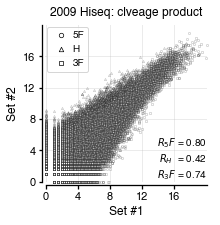

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(f51, f52, s=s, c='w', edgecolor='k', marker='o', lw=lw, alpha=a, label='5F', zorder=2)
ax.scatter(fh1, fh2, s=s, c='w', edgecolor='k', marker='^', lw=lw, alpha=a, label='H', zorder=2)
ax.scatter(f31, f32, s=s, c='w', edgecolor='k', marker='s', lw=lw, alpha=a, label='3F', zorder=2)

ax.set_xticks(range(xmin, xmax, 4))
ax.set_yticks(range(ymin, ymax, 4))
ax.set_xlim(xmin-.4, xmax+.4)
ax.set_ylim(ymin-.4, ymax+.4)
ax.set_xlabel('Set #1', fontsize=12)
ax.set_ylabel('Set #2', fontsize=12)

ax.spines['bottom'].set_bounds(xmin, xmax)
ax.spines['left'].set_bounds(ymin, ymax)
ax.text(xmax,.5,'$R_5F$ = %.2f\n$R_H$  = %.2f\n$R_3F$ = %.2f'%(r5,rh,r3),ha='right')
leg = ax.legend(loc='upper left', handletextpad=.1, markerscale=2)
for lh in leg.legendHandles:
    lh.set_alpha(1)
squ = plt.Rectangle((-.1,-.1), xmax+.1, ymax+.1, fc='w'); ax.add_patch(squ)
ax.grid(clip_path=squ, ls='-', lw=.5)
ax.set_title('2009 Hiseq: clveage product', fontsize=12)
#fig.savefig(resultpath + '200612_s1c_reproducibility_clv.pdf')

### 4. Cleavage productivity

In [50]:
window = 3

In [49]:
inptbl['input'] = inptbl['input_1']+inptbl['input_2']
clvtbl['cleaved'] = clvtbl['cleaved_2']#+clvtbl['cleaved_2']

In [51]:
start, mid, end = 1, 63, 125
clv5f = clvtbl[(clvtbl['rstart']==start)&(clvtbl['rend']<mid)].set_index('Pri-miRNA')
clv3f = clvtbl[(clvtbl['rstart']>mid)&(clvtbl['rend']==end)].set_index('Pri-miRNA')
clvhn = clvtbl[(clvtbl['rstart']<mid)&(clvtbl['rend']>mid)]
clvn5 = clvhn[clvhn['rstart']==start]
clvn3 = clvhn[clvhn['rend']==end]
clvh = clvhn.drop(clvn5.index).drop(clvn3.index).set_index('Pri-miRNA')
clvn5 = clvn5.set_index('Pri-miRNA'); clvn3 = clvn3.set_index('Pri-miRNA')

In [52]:
def fill_unfound(tbl):
    found = set(tbl.index)
    unfound = [ mir for mir in allpris if mir not in found ]
    fill = pd.DataFrame(index=unfound, columns=tbl.columns).fillna(0)
    return tbl.append(fill)

In [53]:
clvtbl = fill_unfound(clvtbl.set_index('Pri-miRNA'))
clv5f = fill_unfound(clv5f)
clv3f = fill_unfound(clv3f)
clvh = fill_unfound(clvh)
clvn5 = fill_unfound(clvn5)
clvn3 = fill_unfound(clvn3)

In [54]:
window = 3
offset = 11

In [65]:
def get_clv_cnts(mir, lib, window):
    ps, pe = preposition[mir]
    if ps<=0 or pe>=125:
        return -1,-1
    invs = ps+offset
    inve = pe-offset
    clv5 = clv5f.loc[[mir]].reset_index().set_index('rend')[lib]
    clv3 = clv3f.loc[[mir]].reset_index().set_index('rstart')[lib]
    prod5 = clv5.reindex(range(ps-1-window,ps+window)).sum()
    prod3 = clv3.reindex(range(pe+1-window,pe+2+window)).sum()
    inv5 = clv5.reindex(range(invs-1-window,invs+window)).sum()
    inv3 = clv3.reindex(range(inve+1-window,inve+2+window)).sum()
    #return int((prod5+prod3)/2), int((inv5+inv3)/2)
    return prod5, inv5

In [66]:
print get_clv_cnts('hsa-mir-6788','cleaved',3)

(704, 669)


In [67]:
clvcnts = { mir:get_clv_cnts(mir,'cleaved',window) for mir in suffinps }
print clvcnts['hsa-let-7a-1']

(44460, 66.0)


In [68]:
def get_productivity(mir, window):
    prod, inv = clvcnts[mir]
    if prod<0: 
        return -999
    inp = inptbl.loc[mir,'input']
    return max(prod-inv,0)/inp

In [69]:
## norm
norm = 'hsa-mir-6788'
norms = get_productivity(norm, window)
print norms

0.0010190711894016596


In [87]:
normprods = {}
for mir in suffinps:
    prod = get_productivity(mir, window)
    if prod>-999:
        normprods[mir] = np.log2(prod/norms+1)

In [70]:
testset = [ 'hsa-mir-144', 'hsa-let-7a-1', 'hsa-mir-17', 'hsa-mir-200a', 'hsa-mir-15a' ]
for mir in testset:
    prod = get_productivity(mir, window)
    print '%s\t%.3f'%(mir,np.log2(prod/norms+1))

hsa-mir-144	11.238
hsa-let-7a-1	11.654
hsa-mir-17	8.839
hsa-mir-200a	10.962
hsa-mir-15a	6.307


In [63]:
#s8 = pd.read_csv('supplementary/201012_s8_cleavage-patterns-srsf3.csv', header=1, index_col=0)

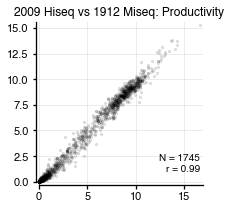

In [165]:
xs = [ s8.loc[m,'CP_w_SRSF3'] for m in s8.index ]
ys = [ normprods[m] for m in s8.index ]
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(xs,ys,s=5,color='k',alpha=.1, zorder=2)
ax.grid(ls='-',lw=.5)
ax.set_xlim(-max(xs)*.02, max(xs)*1.02)
ax.set_ylim(-max(ys)*.02, max(ys)*1.02)
ax.spines['bottom'].set_bounds(0,max(xs)*1.02)
ax.spines['left'].set_bounds(0,max(ys)*1.02)
r = pearsonr(xs,ys)[0]
ax.text(max(xs),1,'N = %s\nr = %.2f'%(len(xs),r), ha='right')
ax.set_title('2009 Hiseq vs 1912 Miseq: Productivity', fontsize=12)
fig.savefig(resultpath + '201015_reproducibility_productivity_2.png',dpi=300)

### 5. Cleavage specificity

In [71]:
rcutoff = 30
fcutoff = .01

In [72]:
def get_frac_5frag(mir):
    sub = clv5f.loc[[mir]].set_index('rend')
    return (sub/sub.sum())

In [73]:
def get_frac_3frag(mir):
    sub = clv3f.loc[[mir]].set_index('rstart')
    return (sub/sub.sum())

In [74]:
def get_frac_hairpin(mir):
    sub = clvh.loc[[mir]].set_index(['rstart','rend'])
    return (sub/sub.sum())

In [75]:
def filter_frac(frac, fcutoff):
    return frac[frac>=fcutoff]

In [76]:
def add_specificity(row):
    row['score'] = (row['5frag']+row['hairpin']+row['3frag'])/3
    return row

In [77]:
def drop_duplicates(sortedtbl):
    if len(sortedtbl)<=1:
        return sortedtbl
    hs = sortedtbl['hstart'].tolist()[0]
    he = sortedtbl['hend'].tolist()[0]
    sub = sortedtbl.iloc[1:]
    sub = sub[(sub['hstart']!=hs)&(sub['hend']!=he)]
    return sortedtbl.iloc[:1].append(drop_duplicates(sub))

In [78]:
frac5f = { mir:get_frac_5frag(mir) for mir in allpris } 
frac3f = { mir:get_frac_3frag(mir) for mir in allpris } 
frachpn = { mir:get_frac_hairpin(mir) for mir in allpris }

In [79]:
COLS = 'miRNA pstart pend hstart hend 5frag 3frag hairpin score diff5 diff3'.split()
def get_dcs(mir, rcutoff, fcutoff, lib):
    ps, pe = preposition[mir]
    null = pd.DataFrame({0:dict(zip(COLS,[mir,ps,pe,1,125,0,0,0,0,99,99]))}).T[COLS]
    clvsites = null
    if clv5f.loc[mir,lib].sum()<30 or clv3f.loc[mir,lib].sum()<30 or clvh.loc[mir,lib].sum()<10:
        return null
    clv5, clv3, clvhpn = [ f[mir][lib] for f in [frac5f,frac3f,frachpn] ]
    clv52 = defaultdict(float); clv52.update(clv5)
    clv32 = defaultdict(float); clv32.update(clv3)
    clvhpn2 = defaultdict(float); clvhpn2.update(clvhpn)
    for c5, frac5 in filter_frac(clv5, fcutoff).items():
        for c3, frac3 in filter_frac(clv3, fcutoff).items():
            row = dict(zip(COLS,[mir,ps,pe,c5+1,c3-1,frac5,frac3,clvhpn2[(c5+1,c3-1)]]))
            clvsites = clvsites.append(row, ignore_index=True)
    for (c5,c3), frach in filter_frac(clvhpn, fcutoff).items():
        row = dict(zip(COLS,[mir,ps,pe,c5,c3,clv52[c5-1],clv32[c3+1],frach]))
        clvsites = clvsites.append(row, ignore_index=True)
    cs = clvsites.apply(add_specificity,axis=1)
    cs['diff5'] = cs['hstart']-cs['pstart']
    cs['diff3'] = cs['pend']-cs['hend']
    cspro = cs[(abs(cs['diff5'])<=window)&(abs(cs['diff3'])<=window)]
    csinv = cs[(abs(cs['diff5']-offset)<=window)&(abs(cs['diff3']-offset)<=window)]
    csall = drop_duplicates(cspro.append(csinv).sort_values('score').iloc[::-1])
    if len(csall)>0:
        return csall
    return null

In [82]:
print time.ctime()
clvall = pd.DataFrame(columns=COLS)
for mir in suffinps:
    clvall = clvall.append(get_dcs(mir, rcutoff, fcutoff, 'cleaved'), ignore_index=True)
clvall = clvall[COLS]
print time.ctime()
print '# of all sites:\t%s' % len(clvall)
print '# of miRNAs:\t%s' % len(set(clvall['miRNA']))

Wed Nov 18 03:56:35 2020
Wed Nov 18 04:24:52 2020
# of all sites:	6466
# of miRNAs:	1815


In [83]:
clvall.to_csv('results/201118/201118_cleavage_specificity_SRSF3_Hiseq.csv')
#clvall = pd.read_csv('results/201015/201015_cleavage_specificity_SRSF3_Hiseq.csv',index_col=0)

In [84]:
clvall.head()

,miRNA,pstart,pend,hstart,hend,5frag,3frag,hairpin,score,diff5,diff3
0,hsa-let-7a-1,25,96,25,96,0.93025,0.977349,0.70461,0.870736,0,0
1,hsa-let-7a-2,28,94,28,94,0.877105,0.954315,0.470297,0.767239,0,0
2,hsa-let-7a-2,28,94,40,82,0.0237157,0.0053599,0.266089,0.0983882,12,12
3,hsa-let-7a-2,28,94,27,95,0.0643651,0.0127403,0,0.0257018,-1,-1
4,hsa-let-7a-2,28,94,41,81,0.00142101,0.000224498,0.032797,0.0114808,13,13


### 6. Cleavage type

In [85]:
effcut = 2.5
homcut = .25
asycut = .25

In [89]:
overlap = [ mir for mir in set(clvall['miRNA']) if mir in normprods ]
print len(overlap)

1812


In [90]:
clvpro = clvall[abs(clvall['diff5'])<=window]
clvinv = clvall[abs(clvall['diff5']-offset)<=window]

In [91]:
def get_single(effcut, homcut, window):
    clvcnts = Counter(clvpro[(clvpro['score']>=homcut)]['miRNA'])
    return [ m for m in clvcnts if clvcnts[m]==1 and normprods[m]>=effcut ]

In [92]:
def get_alternative(effcut, homcut, window):
    clvcnts = Counter(clvpro[(clvpro['score']>=homcut)]['miRNA'])
    return [ m for m in clvcnts if clvcnts[m]>=2 and normprods[m]>=effcut ]

In [94]:
single = get_single(effcut, homcut, window)
alternative = get_alternative(effcut, homcut, window)
dcsmirs = single+alternative
nodcs = [ mir for mir in overlap if mir not in dcsmirs ]

print 'Productive: %s, Unproductive: %s' % (len(dcsmirs), len(nodcs))
print 'Single: %s, Multiple: %s' % (len(single), len(alternative))

Productive: 745, Unproductive: 1067
Single: 688, Multiple: 57


In [96]:
print 'let-7a-1 in unique:', 'hsa-let-7a-1' in single
print 'mir-342 in multiple:', 'hsa-mir-342' in alternative
print 'mir-17 in single:', 'hsa-mir-17' in single
print 'mir-15a in single:', 'hsa-mir-15a' in single

 let-7a-1 in unique: True
mir-342 in multiple: True
mir-17 in single: True
mir-15a in single: True


In [103]:
def get_clv_info(mir, hstart, hend):
    chrom, pstart, pend, strand = s2.loc[mir,['Chr','Start','End','Strand']]
    if strand=='+':
        clv5 = pstart+hstart-1
        clv3 = pstart+hend-1
    else:
        clv5 = pend-hstart+1
        clv3 = pend-hend+1
    return chrom, clv5, clv3, strand

In [99]:
clvtypes = {}
clvtypes.update({mir:'single' for mir in single})
clvtypes.update({mir:'alternative' for mir in alternative})
clvtypes.update({mir:'unproductive' for mir in nodcs})
print len(clvtypes)

1812


In [100]:
cols = [ 'Pri-miRNA', 'Chr', "5' cleavage site", "3' cleavage site", 'Strand', 'Cleavage Score',
         'Cleavage Efficiency', 'Cleavage Homogeneity', 'Cleavage Asymmetry', 'Cleavage Type' ]

In [101]:
effdict = normprods
homdict = { m:max(clvpro[clvpro['miRNA']==m]['score']) for m in set(clvpro['miRNA']) }
asydict = { m:(grp['5frag']-grp['3frag']).sum() for m,grp in clvpro.groupby('miRNA') }

In [104]:
tbl = pd.DataFrame(columns=cols)
for i, row in clvpro.iterrows():
    mir, hs, he, score = row[['miRNA','hstart','hend','score']]
    chrom, cs5, cs3, strand = get_clv_info(mir, hs, he)
    ctype = clvtypes[mir]
    tbl = tbl.append(dict(zip(cols,[mir,chrom,cs5,cs3,strand,score,effdict[mir],homdict[mir],
                                    asydict[mir],clvtypes[mir]])),ignore_index=True)

In [105]:
nonpro = [ mir for mir in overlap if mir not in set(clvpro['miRNA']) ]
for mir in nonpro:
    tbl = tbl.append(dict(zip(cols,[mir,'n.a.',0,0,'n.a.',0,effdict[mir],0,0,clvtypes[mir]])), 
                     ignore_index=True)

In [106]:
tbl = tbl.sort_values('Pri-miRNA').set_index('Pri-miRNA')
print len(set(tbl.index))

1812


### 7. Comparison with Data w/o SRSF

In [138]:
s6uniq = s6[~s6.index.duplicated()]
productive_wo_srsf3 = {m:2**cp-1 for m,cp in s6uniq['Cleavage Productivity'].items()}
productive_w_srsf3 = {m:2**cp-1 for m,cp in normprods.items()}

In [139]:
s6clv = s6[s6['Cleavage Specificity']>0].reset_index()
alternative_wo_srsf3 = { m:2**sorted(grp['Cleavage Specificity'])[-2]-1
                         if len(grp)>1 else 0 for m,grp in s6clv.groupby('Pri-miRNA') }
s8clv = clvall[(clvall['diff'].apply(abs)<=window)&(clvall['cleavage specificity']>0)]
alternative_w_srsf3 = { m:2**sorted(grp['cleavage specificity'])[-2]-1
                        if len(grp)>1 else 0 for m,grp in s8clv.groupby('miRNA') }

In [140]:
nick_wo_srsf3 = { m:grp['Cleavage Imbalance'].sum() for m,grp in s6clv.groupby('Pri-miRNA') }
nick_w_srsf3 = { m:(grp['5frag']-grp['3frag']).sum() for m,grp in s8clv.groupby('miRNA') }

In [141]:
s6det = s6uniq[s6uniq['Cleaved']>0]
inv_wo_srsf3 = (s6det['Inversely cleaved']/s6det['Cleaved']).to_dict()
inv_w_srsf3 = { m:invcnts[m]/clvcnts[m] for m in suffinps if clvcnts[m]>0 }

In [142]:
ovpro = set(productive_wo_srsf3.keys())&set(productive_w_srsf3.keys())
ovalt = set(alternative_wo_srsf3.keys())&set(alternative_w_srsf3.keys())
ovnic = set(nick_wo_srsf3.keys())&set(nick_w_srsf3.keys())
ovinv = set(inv_wo_srsf3.keys())&set(inv_w_srsf3.keys())
ovall = ovpro&ovalt&ovnic&ovinv
print len(ovall)

1584


### 8. Build table

In [143]:
prosmp = s6['Cleavage Productivity'].to_dict()
proclv = s6[abs(s6['Relative position from miRBase site'])<=window]\
.sort_values('Cleavage Specificity')
spesmp = proclv[~proclv.index.duplicated(keep='last')]['Cleavage Specificity'].to_dict()
print len(prosmp), len(spesmp)

1816 1816


In [144]:
clvpro = clvall[(clvall['diff'].apply(abs)<=window)&(clvall['cleavage specificity']>0)]
clvmax = clvpro.sort_values('cleavage specificity', ascending=False).drop_duplicates('miRNA')\
.set_index('miRNA')
print len(clvmax)
clvmax.head()

1677


,pstart,pend,hstart,hend,5frag,3frag,hairpin,cleavage specificity,diff
miRNA,,,,,,,,,
hsa-mir-144,33,89,33,90,0.972045,0.981015,0.953503,0.977356,0
hsa-mir-7-3,31,0,31,90,0.984036,0.974242,0.91808,0.96996,0
hsa-mir-514b,33,90,33,90,0.967623,0.969051,0.938054,0.96956,0
hsa-mir-33a,30,91,30,90,0.980191,0.978877,0.915316,0.969475,0
hsa-mir-125a,31,90,31,90,0.978239,0.958988,0.934122,0.96873,0


In [145]:
mlist = [ mir for mir in overlap if mir in prosmp.keys() ]
mlistpro = [ mir for mir in mlist if mir in clvmax.index ]
mlistnp = [ mir for mir in mlist if mir not in clvmax.index ]
print len(mlist), len(mlistpro), len(mlistnp)

1800 1665 135


In [146]:
def get_clv_info(mir, hstart, hend):
    chrom, pstart, pend, strand = s2.loc[mir,['Chr','Start','End','Strand']]
    if strand=='+':
        clv5 = pstart+hstart-1
        clv3 = pstart+hend-1
    else:
        clv5 = pend-hstart+1
        clv3 = pend-hend+1
    return chrom, clv5, clv3, strand

In [147]:
cols = [ 'Pri-miRNA', 'Chr', "5' cleavage site", "3' cleavage site", 'Strand', 'Cleavage type',
         'CP_wo_SRSF3', 'CP_w_SRSF3', 'CS_wo_SRSF3', 'CS_w_SRSF3', 'Productive_wo_SRSF3',
         'Productive_w_SRSF3', 'Alternative_wo_SRSF3', 'Alternative_w_SRSF3', 'Nick_wo_SRSF3',
         'Nick_w_SRSF3', 'Inverted_wo_SRSF3', 'Inverted_w_SRSF3' ]

In [148]:
tbl = pd.DataFrame(columns=cols)
for mir in mlistpro:
    hs, he, mcs = clvmax.loc[mir,['hstart','hend','cleavage specificity']]
    chrom, cs5, cs3, strand = get_clv_info(mir, hs, he)
    ctype = clvtypes[mir]
    cp_wo_srsf3 = prosmp[mir]
    cp_w_srsf3 = normprods[mir]
    cs_wo_srsf3 = spesmp[mir]
    cs_w_srsf3 = mcs
    if mir in ovall:
        tbl = tbl.append(dict(zip(cols,[mir,chrom,cs5,cs3,strand,ctype,cp_wo_srsf3,cp_w_srsf3, 
                    cs_wo_srsf3,cs_w_srsf3,productive_wo_srsf3[mir],productive_w_srsf3[mir],
                    alternative_wo_srsf3[mir],alternative_w_srsf3[mir],nick_wo_srsf3[mir],
                    nick_w_srsf3[mir],inv_wo_srsf3[mir],inv_w_srsf3[mir]])),ignore_index=True)
    else:
        tbl = tbl.append(dict(zip(cols,[mir,chrom,cs5,cs3,strand,ctype,cp_wo_srsf3,cp_w_srsf3, 
                    cs_wo_srsf3,cs_w_srsf3])),ignore_index=True)

In [149]:
for mir in mlistnp:
    cp_wo_srsf3 = prosmp[mir]
    cp_w_srsf3 = normprods[mir]
    cs_wo_srsf3 = spesmp[mir]
    ctype = clvtypes[mir]
    tbl = tbl.append(dict(zip(cols,[mir,'n.a.','n.a.','n.a.','n.a.',ctype,cp_wo_srsf3,cp_w_srsf3,
                        cs_wo_srsf3,0])), ignore_index=True)

In [150]:
tbl = tbl.sort_values('Pri-miRNA').set_index('Pri-miRNA')
print len(set(tbl.index))

1800


In [151]:
tbl.head()

,Chr,5' cleavage site,3' cleavage site,Strand,Cleavage type,CP_wo_SRSF3,CP_w_SRSF3,CS_wo_SRSF3,CS_w_SRSF3,Productive_wo_SRSF3,Productive_w_SRSF3,Alternative_wo_SRSF3,Alternative_w_SRSF3,Nick_wo_SRSF3,Nick_w_SRSF3,Inverted_wo_SRSF3,Inverted_w_SRSF3
Pri-miRNA,,,,,,,,,,,,,,,,,
hsa-let-7a-1,chr9,94175962,94176033,+,single,5.047200,10.135744,0.912688,0.903606,32.064234,1124.026770,0.017713,0,-0.009062,-0.047099,0.000719,0.001703
hsa-let-7a-2,chr11,122146589,122146523,-,single,4.199327,9.598550,0.838326,0.821497,17.370601,774.267284,0.000000,0.0257018,-0.184113,-0.025585,0.015811,0.024757
hsa-let-7a-3,chr22,46112752,46112821,+,single,2.405940,6.997962,0.584654,0.710909,4.299808,126.819310,0.095455,0.101442,0.001902,0.008724,0.022172,0.004719
hsa-let-7b,chr22,46113691,46113765,+,single,3.906021,9.159402,0.821828,0.810648,13.990958,570.813865,0.009933,0,-0.030746,-0.022305,0.015024,0.002467
hsa-let-7c,chr21,16539838,16539904,+,single,0.553681,8.293256,0.163190,0.737182,0.467826,312.703063,0.008762,0.0336991,0.050677,-0.059746,0.561295,0.026949


In [107]:
tbl.to_csv('resources/201110_s8_cleavage-patterns-srsf3_hiseq.csv')

In [108]:
out = open('supplementary/201110_s8_cleavage-patterns-srsf3_hiseq.csv', 'wt')
description = 'Supplementary Table 8. Microprocessor IVP with SRSF3 \n\n\n\n\n'
out.write(description)
for l in open('resources/201110_s8_cleavage-patterns-srsf3_hiseq.csv', 'rt'):
    out.write(l)
out.close()

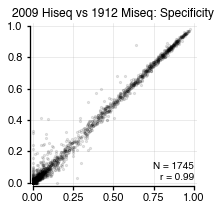

In [163]:
xs = [ s8.loc[m,'CS_w_SRSF3'] for m in s8.index ]
ys = [ tbl.loc[m,'CS_w_SRSF3'] for m in s8.index ]
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(xs,ys,s=5,color='k',alpha=.1, zorder=2)
ax.grid(ls='-',lw=.5)
ax.set_xlim(-.02, 1.02)
ax.set_ylim(-.02, 1.02)
ax.spines['bottom'].set_bounds(0,1)
ax.spines['left'].set_bounds(0,1)
r = pearsonr(xs,ys)[0]
ax.text(1,.02,'N = %s\nr = %.2f'%(len(xs),r), ha='right')
ax.set_title('2009 Hiseq vs 1912 Miseq: Specificity', fontsize=12)
fig.savefig(resultpath + '201015_reproducibility_specificity_2.png',dpi=300)